<a href="https://colab.research.google.com/github/rachitmathur89/Google_Colab/blob/main/Object_Classification_Using_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount drive to access dataset


*   [click](https://drive.google.com/drive/folders/10Uqr_lQUgamXQs5Z43PKwwuCRx6hG52b?usp=sharing) here to see the furniture dataset in drive
*   create shortcut to the My Drive folder
*   Run the below code to access from drive and upload to session storage







In [13]:
from google.colab import drive
from pathlib import Path
drive.mount("/gdrive", force_remount=True)


Mounted at /gdrive


In [14]:
%load_ext autoreload
%autoreload 2

import sys

from pathlib import Path
base = Path('/gdrive/My Drive/furniture-images/img/')
sys.path.append(str(base))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
zip_path = base/'furniture_images.zip'
!cp "{zip_path}" .
!unzip -q furniture_images.zip
!rm furniture_images.zip

### Import Libraries



In [16]:
import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import os
import random

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Access the downloaded dataset in the colab
Access the dataset directories and images

In [17]:
base_dir = 'furniture-images/img'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
category = os.listdir(train_dir)

In [18]:

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 1
ncols = 8

# Index for iterating over images
pic_index = 0

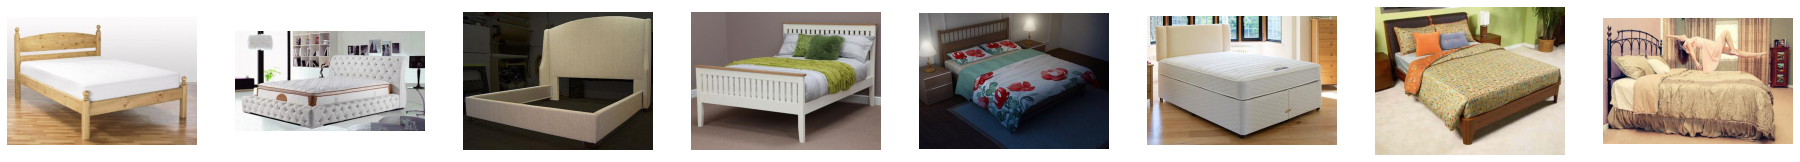

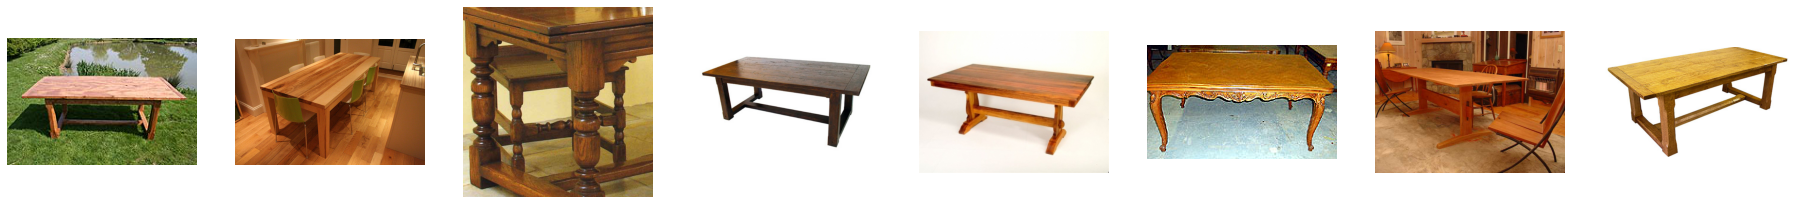

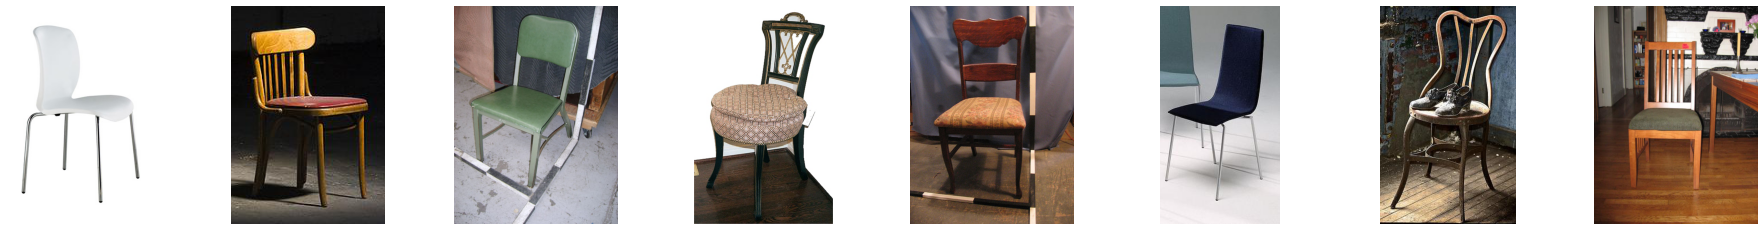

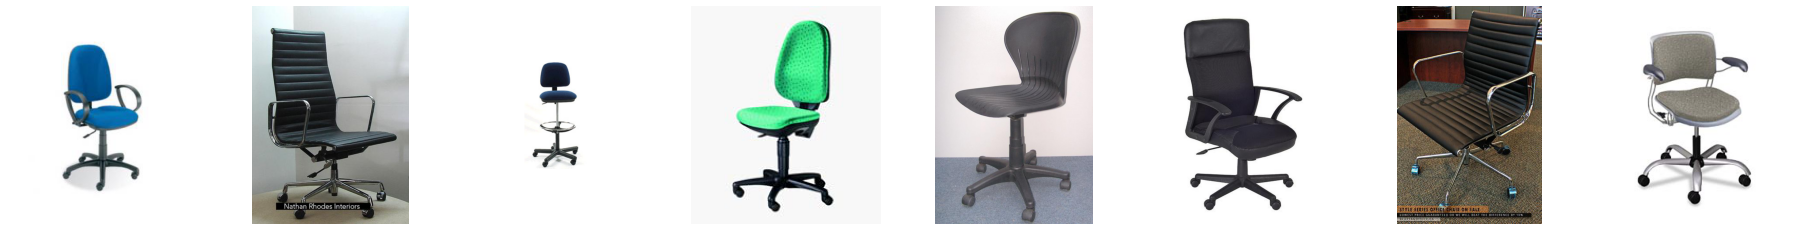

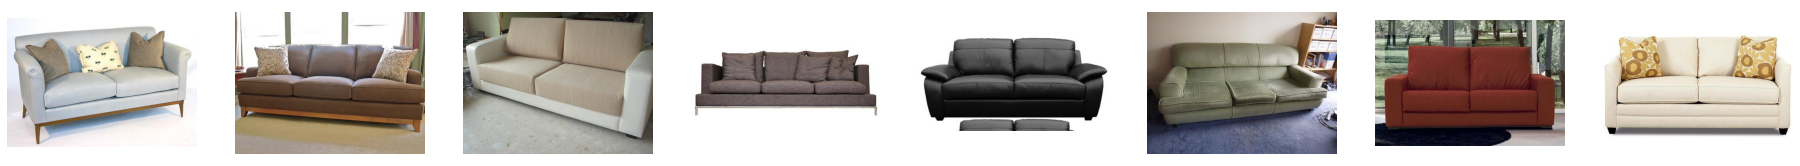

In [19]:


pic_index += 8

for it in category:
  # Set up matplotlib fig, and size it to fit 4x4 pics
  fig = plt.gcf()
  fig.set_size_inches(ncols * 4, nrows * 4)
  train_cat_dir = os.path.join(train_dir, it)
  train_cat_fnames = os.listdir(train_cat_dir)
  next_pix = [os.path.join(train_cat_dir, fname) 
                  for fname in train_cat_fnames[pic_index-8:pic_index]]

  for i, img_path in enumerate(next_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

  plt.show()

In [20]:
train_files = sum([len(files) for i, j, files in os.walk(train_dir)])
val_files = sum([len(files) for i, j, files in os.walk(val_dir)])
print(train_files, val_files)

4024 423


Set the hyperparameters

In [21]:

n_classes = 5
epochs = 5
nb_train_samples = train_files
nb_validation_samples = val_files
num_epochs = epochs



img_width, img_height = 150, 150
train_data_dir = train_dir
validation_data_dir = val_dir
batch_size = 16



### Build a Model using tensorflow.keras.layers library
Model is using 3 convolution hidden layers with filter size 3 and activation function relu. The output layer has 5 output neurons with action function softmax

In [22]:


# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

In [23]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with 5 nodes and softmax activation
output = layers.Dense(5, activation='softmax')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

### Print model summary Plot the model architecture
Model architecture (model_plot.png image) is saved in the root folder of the session by running the below code.

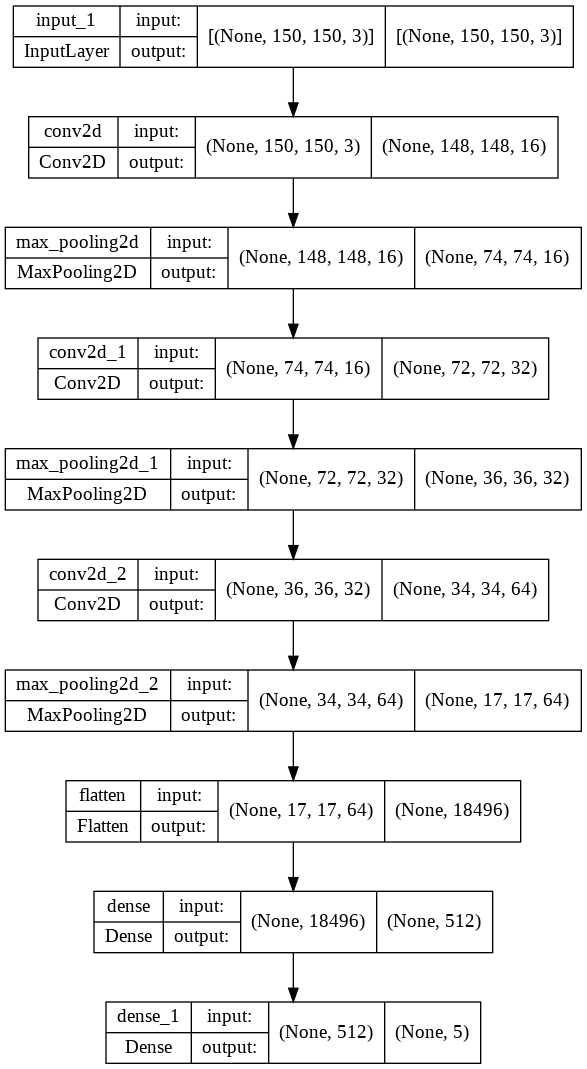

In [24]:

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [25]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496 

### Run the model

In [26]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


Found 4024 images belonging to 5 classes.
Found 423 images belonging to 5 classes.


In [28]:
history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=num_epochs,
                    verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
251/251 [==============================] - 125s 494ms/step - loss: 0.9694 - accuracy: 0.6357 - val_loss: 0.5731 - val_accuracy: 0.7812
Epoch 2/5
251/251 [==============================] - 123s 491ms/step - loss: 0.5594 - accuracy: 0.7982 - val_loss: 0.5006 - val_accuracy: 0.8365
Epoch 3/5
251/251 [==============================] - 125s 499ms/step - loss: 0.4548 - accuracy: 0.8388 - val_loss: 0.5192 - val_accuracy: 0.8245
Epoch 4/5
251/251 [==============================] - 124s 493ms/step - loss: 0.3639 - accuracy: 0.8743 - val_loss: 0.3753 - val_accuracy: 0.8798
Epoch 5/5
251/251 [==============================] - 123s 490ms/step - loss: 0.3069 - accuracy: 0.8992 - val_loss: 0.3865 - val_accuracy: 0.8702


### Plot the Results
Show the accuracy and loss variations per epoch in the graph

In [29]:

history.history

{'accuracy': [0.6357285380363464,
  0.7981536984443665,
  0.8388223648071289,
  0.8742514848709106,
  0.8992015719413757],
 'loss': [0.969398021697998,
  0.5594399571418762,
  0.4547533392906189,
  0.36387163400650024,
  0.30685609579086304],
 'val_accuracy': [0.78125,
  0.8365384340286255,
  0.8245192170143127,
  0.879807710647583,
  0.870192289352417],
 'val_loss': [0.5731391310691833,
  0.5006194114685059,
  0.5191835761070251,
  0.37530311942100525,
  0.38652706146240234]}

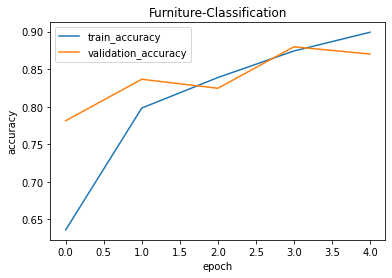

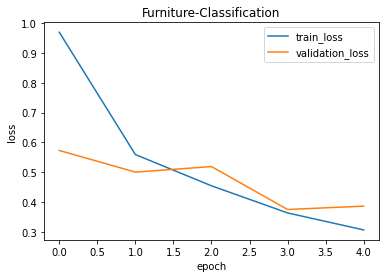

In [30]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'Furniture-Classification')
plot_loss(history,'Furniture-Classification')